# main

导入环境

In [94]:
import torch
import torch.nn as nn
import pandas as pd
from scipy.ndimage import gaussian_filter1d,uniform_filter1d
from torch.utils.data import Dataset
import numpy as np
from scipy.stats import linregress
from scipy.optimize import minimize
from tqdm import tqdm
from itertools import product
from scipy.special import huber
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

加载数据并滤波

In [95]:
df = pd.read_pickle('./loss curves/gpt_loss+lrs.pkl')
df_811 = df['M:100M_gpt_D:20B_scheduler:811_rope']
df_wsd = df['M:100M_gpt_D:20B_scheduler:wsd_rope']
df_cos = df['M:100M_gpt_D:20B_scheduler:cosine_rope']

df_811['S1'] = np.cumsum(df_811['lr'])
df_wsd['S1'] = np.cumsum(df_wsd['lr'])
df_cos['S1'] = np.cumsum(df_cos['lr'])

# 滤波

# data_811['loss_filter']=uniform_filter1d(data_811['Metrics/loss'], size=5)
# data_wsd['loss_filter']=uniform_filter1d(data_wsd['Metrics/loss'], size=5)
# data_cos['loss_filter']=uniform_filter1d(data_cos['Metrics/loss'], size=5)

df_811['loss_filter']=gaussian_filter1d(df_811['Metrics/loss'], sigma=1.5)
df_wsd['loss_filter']=gaussian_filter1d(df_wsd['Metrics/loss'], sigma=1.5)
df_cos['loss_filter']=gaussian_filter1d(df_cos['Metrics/loss'], sigma=1.5)

print(df_811.shape,df_811.head())
a=df_811['Metrics/loss'].to_numpy()
a[torch.tensor([0,1],dtype=torch.int32)]

(33908, 5)    step  Metrics/loss     lr     S1  loss_filter
0     0     10.403171  0.001  0.001    10.401701
1     1     10.402224  0.001  0.002    10.399595
2     2     10.400403  0.001  0.003    10.394132
3     3     10.393160  0.001  0.004    10.383107
4     4     10.371922  0.001  0.005    10.363682


array([10.40317059, 10.40222359])

定义模型 (Tissue2024)

In [96]:
class Model_tissue(nn.Module):
    """
    Args:
        L0,A,alpha,C,lamb
    """
    def __init__(self, df_train: pd.DataFrame,
                L0: float, A: float, alpha: float,
                C: float, lamb: float):
        super().__init__()
        self.L0 = nn.Parameter(torch.tensor(L0, dtype=torch.float64))
        self.A = nn.Parameter(torch.tensor(A, dtype=torch.float64))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float64))
        self.C = nn.Parameter(torch.tensor(C, dtype=torch.float64))
        self.lamb = nn.Parameter(torch.tensor(lamb, dtype=torch.float64))
        self.data_lr = torch.from_numpy(df_train['lr'].to_numpy())
        self.data_S1 = torch.from_numpy(df_train['S1'].to_numpy())
        self.data_loss = torch.from_numpy(df_train['loss_filter'].to_numpy())

    def forward(self,step_batch: torch.tensor):
        S1 = self.data_S1[step_batch]
        S2 = torch.zeros_like(step_batch, dtype=torch.float64)
        for i, s in enumerate(step_batch):
            # 计算S2
            j_indices = torch.arange(1,s+1,1,dtype=torch.int32)
            S2[i] = torch.sum( # sigma _j=1 ^s
                (self.data_lr[j_indices-1]-self.data_lr[j_indices])*(1-torch.pow(self.lamb,s+1-j_indices))/(1-self.lamb)
                )
        pred = self.L0 + self.A * S1 ** (-self.alpha) - self.C * S2
        r = torch.log(self.data_loss[step_batch]) - torch.log(pred.clamp(min=1e-10))  # Avoid log(0)

        # huber loss
        delta = 1e-3
        huber_loss = torch.where(torch.abs(r) < delta, 0.5 * r ** 2, delta * (torch.abs(r) - 0.5 * delta))
        return huber_loss.sum()

定义模型参数初始化方法

In [97]:
def initialize_params_tissue(df_train: pd.DataFrame, step_batch: list):
    min_loss = df_train['loss_filter'].min()
    log_y = np.log(df_train["loss_filter"][step_batch] - min_loss + 1e-3)
    log_x = np.log(df_train["S1"][step_batch])
    slope, intercept, _, _, _ = linregress(log_x, log_y)

    L0_init_set = np.linspace(min_loss - 0.2, min_loss + 0.2, 5)
    A_init_set = np.linspace(np.exp(intercept) - 0.1, np.exp(intercept) + 0.1, 3)
    alpha_init_set = np.linspace(-slope - 0.1, -slope + 0.1, 3)
    C_init_set = np.linspace(100, 1000, 3)

    def loss_fn0(params):
        L0, A, alpha, C = params
        pred = L0 + A * df_train["S1"][step_batch] ** (-alpha) - C * (3e-4 - df_train["lr"][step_batch])
        r = np.log(df_train["loss_filter"][step_batch]) - np.log(pred+1e-10)
        return huber(1e-3,r).sum()

    init_params = list(product(L0_init_set, A_init_set, alpha_init_set, C_init_set))
    best_loss = float('inf')
    best_params = None

    for init_param in tqdm(init_params, desc="Initializing Parameters"):
        res = minimize(
            loss_fn0, init_param, method='L-BFGS-B', bounds=[(0, np.inf)] * 4,
            options={'maxiter': 100000, 'ftol': 1e-9, 'gtol': 1e-6, 'eps': 1e-8}
        )
        if res.fun < best_loss:
            best_loss = res.fun
            best_params = res.x
    return dict(zip(['L0', 'A', 'alpha', 'C'],best_params))

定义模型优化方法

In [98]:
def model_fit(train,model,step_batch,max_step=200,loss_thr=1e-10,patience=20,grad_norm_thr=1e-5):
    optimizer = torch.optim.AdamW([
            {"params": [model.L0, model.A, model.C], "lr": 0.05},
            {"params": [model.alpha, model.lamb], "lr": 0.005},
        ])
    loss_history, min_loss, steps_no_improve = [], float('inf'), 0
    best_params, best_loss = None, float('inf')

    for _ in tqdm(range(max_step), desc="Training Progress"):
        optimizer.zero_grad()
        total_loss = model(step_batch)
        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            total_loss = model(step_batch)
        loss_history.append(total_loss.item())

        if total_loss < min_loss - loss_thr:
            min_loss = total_loss.item()
            steps_no_improve = 0
        else:
            steps_no_improve += 1

        if steps_no_improve >= patience:
            break

        grads = [p.grad.flatten() for p in model.parameters() if p.grad is not None]
        grad_norm = torch.cat(grads).norm() if grads else torch.tensor(0.0)
        if grad_norm < grad_norm_thr:
            break

        if total_loss < best_loss:
            best_loss = total_loss.item()
            best_params = [p.item() for p in model.parameters()]

    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(loss_history)), loss_history, label="Fitting loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./tissue_train_{train:s}_fit_monitor.png")

    return best_params, best_loss

定义后处理

In [99]:
from matplotlib.patches import  ConnectionPatch
def zone_and_linked(ax,axins,xleft,xright,x,y):
    """缩放内嵌图形，并且进行连线
    ax:         画布. e.g. fig,ax = plt.subplots()
    axins:      内嵌图的画布. e.g. axins = ax.inset_axes((0.4,0.1,0.4,0.3))
    xleft:  要放大区域的横坐标左端点刻度值
    xright: 要放大区域的横坐标右端点刻度值
    x:          X值array(需按单调非减排列)
    y:          所有y值array的列表 [y1,y2,y3......]
                注意x,yi的索引需要为默认索引0,1,2...(若pandas.seires可能不是)
    linked:     进行连线的位置，{'bottom','top','left','right'}
    """
    zone_left=(abs(x-xleft)).argmin() # 获取xleft在x数组中最接近的索引
    zone_right=(abs(x-xright)).argmin() # 获取xright在x数组中最接近的索引
    xlim_left = x[zone_left]-(x[zone_right]-x[zone_left])*0.05
    xlim_right = x[zone_right]+(x[zone_right]-x[zone_left])*0.05

    y_data = np.hstack([yi[zone_left:zone_right] for yi in y])
    ylim_bottom = np.min(y_data)-(np.max(y_data)-np.min(y_data))*0.05
    ylim_top = np.max(y_data)+(np.max(y_data)-np.min(y_data))*0.05

    axins.set_xlim(xlim_left, xlim_right)
    axins.set_ylim(ylim_bottom, ylim_top)

    # 在原图中将被放大区域进行红色虚线框标注
    ax.plot([xlim_left,xlim_right,xlim_right,xlim_left,xlim_left],
            [ylim_bottom,ylim_bottom,ylim_top,ylim_top,ylim_bottom],
            color="#86A0BE",linestyle='--',linewidth=1.0)

    # 连接原图中被放大区域与局部放大图
    xyA_1, xyB_1 = (xlim_left,ylim_bottom), (xlim_left,ylim_top)
    xyA_2, xyB_2 = (xlim_right,ylim_bottom), (xlim_right,ylim_top)
    con = ConnectionPatch(xyA=xyA_1,xyB=xyB_1,coordsA="data",
                          coordsB="data",axesA=axins,axesB=ax,
                          linestyle='--',color='#86A0BE',linewidth=1.0)
    axins.add_artist(con)
    con = ConnectionPatch(xyA=xyA_2,xyB=xyB_2,coordsA="data",
                          coordsB="data",axesA=axins,axesB=ax,
                          linestyle='--',color='#86A0BE',linewidth=1.0)
    axins.add_artist(con)

In [100]:
class Model_eval_tissue:
    def __init__(self, df: pd.DataFrame, fig_id : str,train_id: str,
                L0: float, A: float, alpha: float,
                C: float, lamb: float,):
        super().__init__()
        self.fig_id = fig_id
        self.train_id = train_id
        self.L0 = (torch.tensor(L0, dtype=torch.float64))
        self.A = (torch.tensor(A, dtype=torch.float64))
        self.alpha = (torch.tensor(alpha, dtype=torch.float64))
        self.C = (torch.tensor(C, dtype=torch.float64))
        self.lamb = (torch.tensor(lamb, dtype=torch.float64))
        self.data_lr = torch.from_numpy(df['lr'].to_numpy())
        self.data_S1 = torch.from_numpy(df['S1'].to_numpy())
        self.data_loss = torch.from_numpy(df['loss_filter'].to_numpy())
        self.data_loss_ori = torch.from_numpy(df['Metrics/loss'].to_numpy())

    def forward(self,step_batch:torch.tensor):
        S1 = self.data_S1[step_batch]
        S2 = torch.zeros_like(step_batch, dtype=torch.float64)
        for i, s in enumerate(step_batch):
            # 计算S2
            j_indices = torch.arange(1,s+1,1,dtype=torch.int32)
            S2[i] = torch.sum( # sigma _j=1 ^s
                (self.data_lr[j_indices-1]-self.data_lr[j_indices])*(1-torch.pow(self.lamb,s+1-j_indices))/(1-self.lamb)
                )
        pred = self.L0 + self.A * S1 ** (-self.alpha) - self.C * S2
        r = torch.log(self.data_loss[step_batch]) - torch.log(pred.clamp(min=1e-10))  # Avoid log(0)

        # huber loss
        delta = 1e-3
        huber_loss = torch.where(torch.abs(r) < delta, 0.5 * r ** 2, delta * (torch.abs(r) - 0.5 * delta))

        # 绘图
        # 字体配置
        font = {
            'family': 'serif',
            'weight': 'normal',
            'size': 12  # 设置字体大小
        }
        plt.rc('font', **font)  # 应用字体配置
        plt.rc('xtick', direction='in')  # x 刻度线向内
        plt.rc('ytick', direction='in')  # y 刻度线向内
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(step_batch, self.data_loss_ori[step_batch], label=f"{self.fig_id}: original", linestyle="--",linewidth=1.5,color='#E39B96')
        ax.scatter(step_batch, self.data_loss[step_batch], label=f"{self.fig_id}: filtered", facecolors='#9FACC0',edgecolors='#415686',marker='o',s=15)
        ax.plot(step_batch, pred, label=f"{self.fig_id}: predict", linestyle="-",linewidth=1.5,color='#D64637')
        ax.legend(frameon=False)
        ax.set(xlabel='Step',ylabel='Loss')
        axins1 = ax.inset_axes((0.25, 0.25, 0.7, 0.5))
        axins1.plot(step_batch, self.data_loss_ori[step_batch], label=f"{self.fig_id}: original", linestyle="--",linewidth=1.0,color='#E39B96')
        axins1.scatter(step_batch, self.data_loss[step_batch], label=f"{self.fig_id}: filtered", facecolors='#9FACC0',edgecolors='#415686',marker='o',s=30)
        axins1.plot(step_batch, pred, label=f"{self.fig_id}: predict", linestyle="-",linewidth=1.5,color='#D64637')
        axins1.spines[:].set_color('#86A0BE')
        axins1.spines['top'].set_linestyle('--')         
        axins1.spines['right'].set_linestyle('--')        
        axins1.spines['bottom'].set_linestyle('--')             
        axins1.spines['left'].set_linestyle('--') 
        zone_and_linked(ax, axins1, 25000, 30000, step_batch, [self.data_loss_ori[step_batch],self.data_loss[step_batch],pred])

        
        fig.savefig(f"tissue_train_{self.train_id}_eval_{self.fig_id}.png")
        return huber_loss.sum()

定义LRS优化方法

In [101]:
def lrs_opt(L0, A, alpha, C, lamb,
        total_steps=24000,
        peak_lr=3e-4,
        min_lr=1e-10,
        lr=5e-9,
        max_steps=10000,
        warmup=2160,
        ):

    '''
    Args:
        Fitted MPL parameters [L0, A, alpha, C, lamb].
        total_steps (int): Total steps in the schedule.
        peak_lr (float): Initial peak learning rate.
        min_lr (float): Minimum learning rate threshold.
        lr (float): Learning rate for optimization.
        max_steps (int): Maximum optimization steps.
        warmup (int): Number of warmup steps.
        name (str): Identifier for output files.
    '''

    # Initialize Delta (learnable LR reductions)
    delta = nn.Parameter(torch.zeros(total_steps - warmup, dtype=torch.float64), requires_grad=True)
    warmup_bias = 0.5 * peak_lr * warmup
    optimizer = torch.optim.Adam([delta], lr=lr)
    '''
            S1 = self.data_S1[step_batch]
            S2 = torch.zeros_like(step_batch, dtype=torch.float64)
            for i, s in enumerate(step_batch):
                # 计算S2
                j_indices = torch.arange(1,s+1,1,dtype=torch.int32)
                S2[i] = torch.sum( # sigma _j=1 ^s
                    (self.data_lr[j_indices-1]-self.data_lr[j_indices])*(1-torch.pow(self.lamb,s+1-j_indices))/(1-self.lamb)
                    )
            pred = self.L0 + self.A * S1 ** (-self.alpha) - self.C * S2
    '''
    # Optimization loop
    for _ in tqdm(range(max_steps), desc="Optimizing LR Schedule"):
        optimizer.zero_grad()

        # Compute LR schedule from Delta
        eta = peak_lr - torch.cumsum(delta.clamp(min=0), dim=0)
        eta = torch.clamp(eta, min=min_lr)

        S1 = torch.cumsum(eta, dim=0) + warmup_bias
        S1 = torch.concatenate([torch.tensor([0]), S1], dim=0)

        s = total_steps - warmup -1

        j_indices = torch.arange(1,s+1,1,dtype=torch.int32)
        S2 = torch.sum( # sigma _j=1 ^s
            (eta[j_indices-1]-eta[j_indices])*(1-torch.pow(lamb,s+1-j_indices))/(1-lamb)
            )

        pred = L0 + A * S1[-1] ** (-alpha) - C * S2
        pred.backward()
        optimizer.step()

        # Enforce constraints
        with torch.no_grad():
            delta.clamp_(min=0, max=peak_lr)
            eta = peak_lr - torch.cumsum(delta, dim=0)
            delta.masked_fill_(eta <= min_lr, 0)
            opt_lr = eta.detach().numpy()
            loss = pred.item()

    # 优化结果: opt_lr -> np.save('luo_opt_lr.npy', opt_lr)
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(warmup, total_steps), opt_lr,label='LRS')
    plt.grid(True)
    plt.xlabel("Step")
    plt.ylabel("Learning rate")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("tissue_opt_lr.png")
    plt.close()
    print(f"Final loss for optimal LRS: {loss}")
    return None

主函数：一个用于训练，两个用于测试

In [102]:
def main(train='811',test1='wsd',test2='cos',train_steps=100,eval_steps=100,
         df_dict={'811':df_811,'wsd':df_wsd,'cos':df_cos}):
    """
    Main function to run the model fitting and evaluation.
    train_steps(int): Number of steps for training.
    """
    print(f"step.min()={df_dict[train]['step'].min()}, step.max()={df_dict[train]['step'].max()}, train_steps={train_steps}")
    step_batch = np.linspace(df_dict[train]['step'].min()+1, df_dict[train]['step'].max()-1, train_steps, dtype=int)
    eval_batch = torch.linspace(df_dict[train]['step'].min()+1, df_dict[train]['step'].max()-1, eval_steps, dtype=torch.int32)

    # 参数初始化
    init_params = initialize_params_tissue(df_dict[train],step_batch)
    init_params['lamb'] = 0.995
    model=Model_tissue(df_dict[train],**init_params)

    # 模型拟合 best_params = [L0, A, alpha, C, lamb]
    step_batch = torch.tensor(step_batch,dtype=torch.int32)
    best_params, train_best_loss = model_fit(train,model,step_batch)

    # 检验拟合结果
    m1 = Model_eval_tissue(df_dict[train],train,train,*best_params)
    m2 = Model_eval_tissue(df_dict[test1],test1,train,*best_params)
    m3 = Model_eval_tissue(df_dict[test2],test2,train,*best_params)
    train_loss = m1.forward(eval_batch)
    test1_loss = m2.forward(eval_batch)
    test2_loss = m3.forward(eval_batch)

    # 打印结果
    print('====================')
    print(f'[train]  {train:s} fit_loss:{train_best_loss:.4e}')
    print(f"[ eval ] {train:s}: {train_loss:.4e}, {test1:s}: {test1_loss:.4e}, {test2:s}: {test2_loss:.4e}")
    print(f'[metric] test1+test2: {test1_loss+test2_loss:.4e}')
    print('====================')

    # LRS优化
    warmup = 2000
    total_steps = df_dict[train]['step'].max() + 1 + warmup
    lrs_opt(*best_params,warmup=warmup,total_steps=total_steps)

主程序 (作业要求一个数据集用于训练，两个数据集用于测试)

step.min()=0, step.max()=33907, train_steps=300


Training Progress:  78%|███████▊  | 157/200 [00:53<00:14,  2.92it/s]


[train]  811 fit_loss:1.4446e+00
[ eval ] 811: 1.4446e+00, cos: 4.1006e+00, wsd: 1.1695e+00
[metric] test1+test2: 5.2701e+00


Optimizing LR Schedule: 100%|██████████| 10000/10000 [00:19<00:00, 516.08it/s]


Final loss for optimal LRS: 1.051996381047244


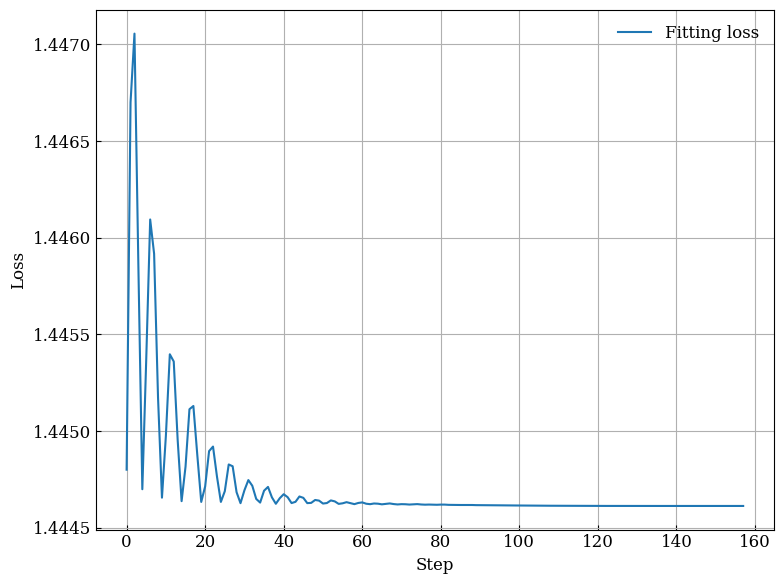

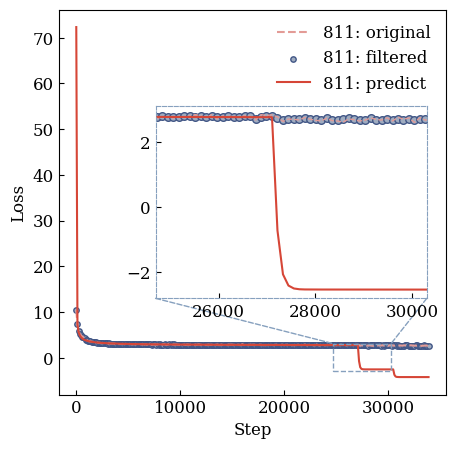

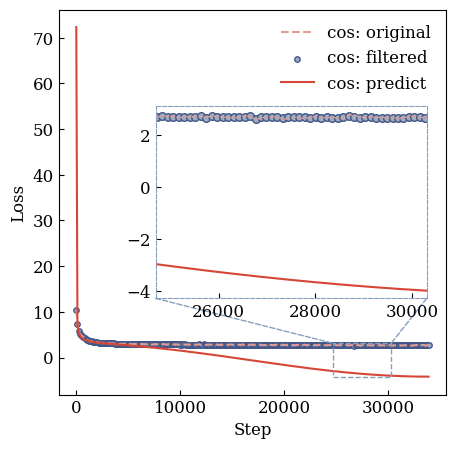

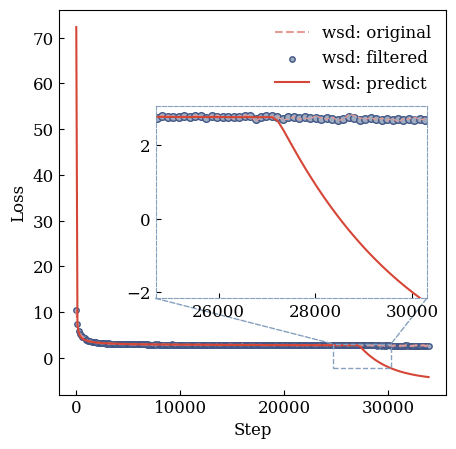

In [103]:
main(train='811', test1='cos', test2='wsd', train_steps=300,eval_steps=300,)

step.min()=0, step.max()=33907, train_steps=300


Training Progress: 100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


[train]  cos fit_loss:1.6826e-02
[ eval ] cos: 1.6826e-02, 811: 2.8488e-02, wsd: 2.8241e-02
[metric] test1+test2: 5.6730e-02


Optimizing LR Schedule: 100%|██████████| 10000/10000 [00:16<00:00, 616.84it/s]


Final loss for optimal LRS: 3.0820672418973847


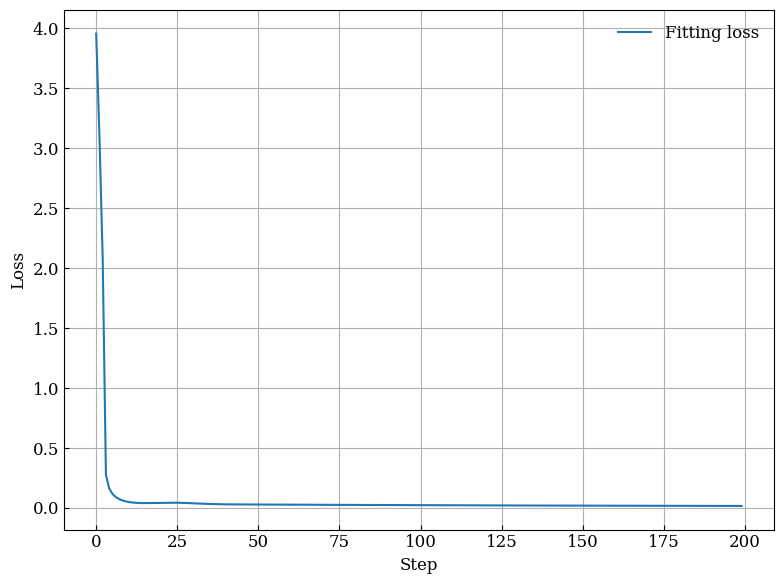

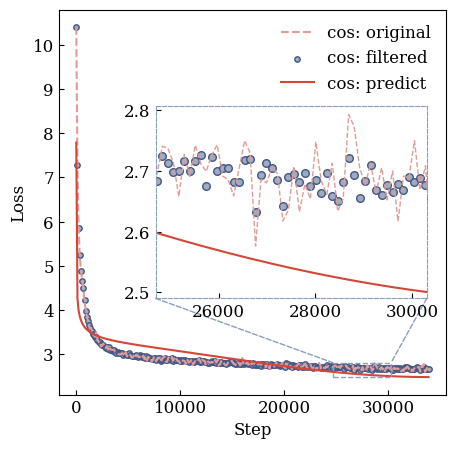

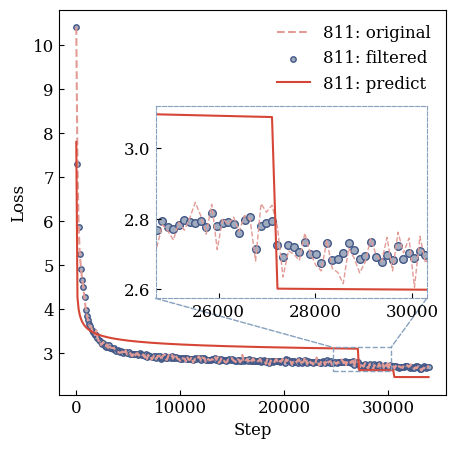

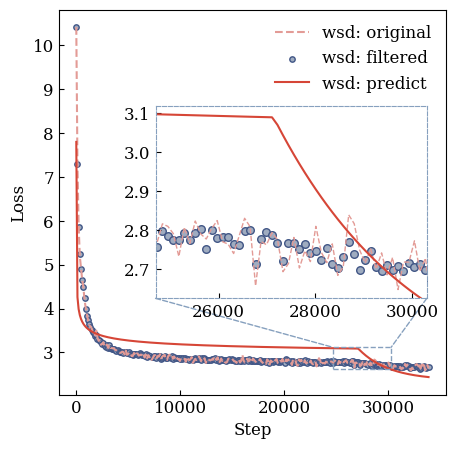

In [104]:
main(train='cos', test1='811', test2='wsd', train_steps=300,eval_steps=300,)

step.min()=0, step.max()=33907, train_steps=300


Training Progress: 100%|██████████| 200/200 [01:13<00:00,  2.70it/s]


[train]  wsd fit_loss:1.1977e-02
[ eval ] wsd: 1.1977e-02, cos: 2.9962e-02, 811: 1.4495e-02
[metric] test1+test2: 4.4457e-02


Optimizing LR Schedule: 100%|██████████| 10000/10000 [00:22<00:00, 448.26it/s]


Final loss for optimal LRS: 2.7898021004846516


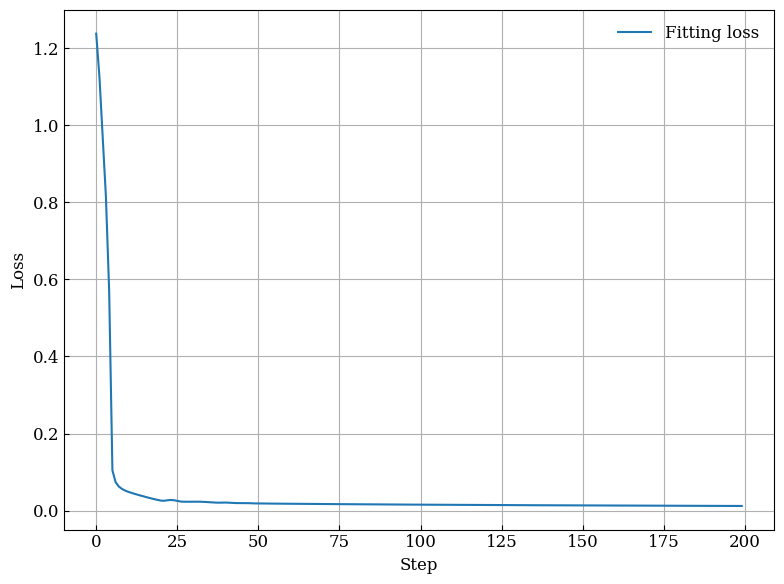

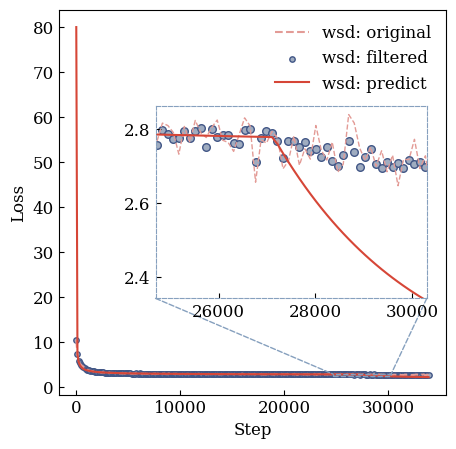

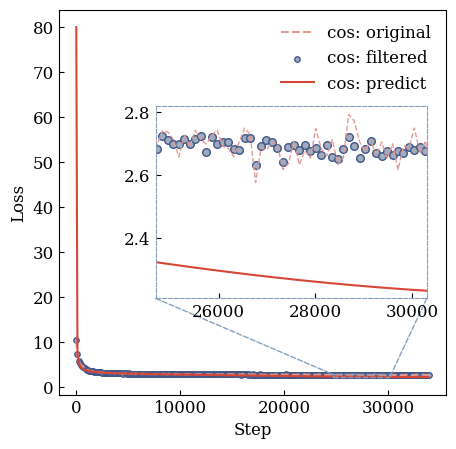

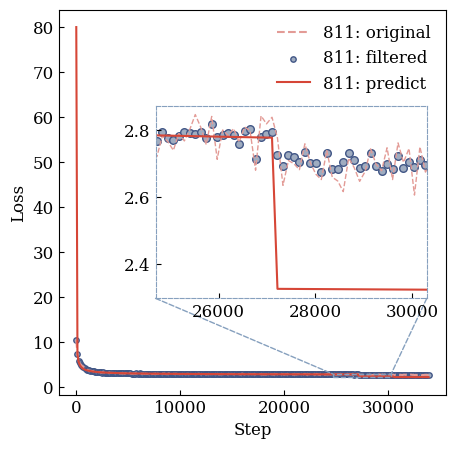

In [105]:
main(train='wsd', test1='cos', test2='811', train_steps=300,eval_steps=300,)